In [1]:
import torch 

In [2]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import CIFAR100 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train = CIFAR100(root='./data', train=True, download=True, transform=transform)
test = CIFAR100(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)
train_subset = torch.utils.data.Subset(train, range(5000))  # Use only 5000 samples
train_loader_fast = DataLoader(train_subset, batch_size=32, shuffle=True)  # Smaller batch

Files already downloaded and verified
Files already downloaded and verified


In [4]:
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    print(f"Batch of images shape: {images.shape}, Batch of labels shape: {labels.shape}")
    break  # Just to check the first batch

Batch of images shape: torch.Size([64, 3, 224, 224]), Batch of labels shape: torch.Size([64])


In [5]:
from torchvision import models

model = models.resnet18(pretrained=True)
model = model.to(device)

c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = vgg16.to(device)

c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
efficientnet = models.efficientnet_b0(pretrained=True)
efficientnet = efficientnet.to(device)

c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


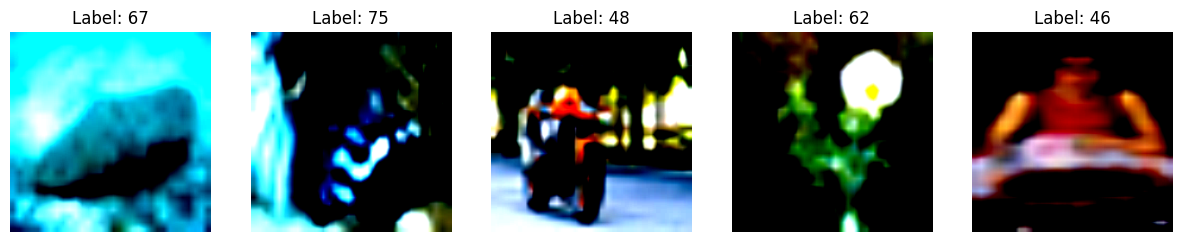

In [7]:

### learn more about dataset first 

def view_dataset(dataset):
    print(f"Number of samples: {len(dataset)}")
    print(f"Sample data shape: {dataset[0][0].shape}, Sample label: {dataset[0][1]}")


## view random images 


def view_random_images(dataset, num_images=5):
    import matplotlib.pyplot as plt
    import numpy as np

    indices = np.random.choice(len(dataset), num_images, replace=False)
    images, labels = zip(*[dataset[i] for i in indices])

    images = torch.stack(images).cpu().numpy()
    labels = np.array(labels)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.show()


# Example usage
view_random_images(train, num_images=5)






In [35]:
#### Model Preparation and Training 


# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes=100):
#         vgg16 = models.vgg16(pretrained=True)
#         super(SimpleCNN, self).__init__()
#         self.features = vgg16.features
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 7 * 7, 4096),
#             nn.ReLU(),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(),
#             nn.Dropout(),
#             nn.Linear(4096, num_classes)
#         )
#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x
# model = SimpleCNN(num_classes=100).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
class FastVGG(nn.Module):
    def __init__(self, num_classes=100):
        super(FastVGG, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features
        
        # Freeze ALL feature layers
        for param in self.features.parameters():
            param.requires_grad = False
            
        # Simpler classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Use the faster model
fast_model = FastVGG(num_classes=100).to(device)
optimizer_fast = torch.optim.Adam(fast_model.parameters(), lr=0.001)
from torch.cuda.amp import GradScaler, autocast
criterion = nn.CrossEntropyLoss()
def fast_train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    scaler = GradScaler()
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            
            # Print progress every 100 batches
            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        print(f"Epoch [{epoch+1}/{num_epochs}] Complete, Avg Loss: {running_loss/len(train_loader):.4f}")

c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
# fast_train_model(fast_model, train_loader_fast, criterion, optimizer_fast, num_epochs=5)

In [39]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
evaluate_model(model, test_loader)




Accuracy of the model on the test set: 0.36%


In [ ]:
#### Write Code FOr Other Models

class Reset18ForCIFAR100(nn.Module):
    def __init__(self):
        super(Reset18ForCIFAR100, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 100)  # 512 -> 100 classes

    def forward(self, x):
        return self.resnet(x)
    

class EfficientNetForCIFAR100(nn.Module):
    def __init__(self):
        super(EfficientNetForCIFAR100, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, 100)  # 1280 -> 100 classes

    def forward(self, x):
        return self.efficientnet(x)
    


## Both models can be easily adapted:

resnet = Reset18ForCIFAR100().to(device)
efficientnet = EfficientNetForCIFAR100().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet.parameters(), lr=0.001)
optimizer_efficientnet = torch.optim.Adam(efficientnet.parameters(), lr=0.001)


def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")



train_model(resnet, train_loader_fast, criterion, optimizer_resnet, num_epochs=5)

# train_model(efficientnet, train_loader, criterion, optimizer_efficientnet, num_epochs=5)


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
# evaluate_model(resnet, test_loader)
# evaluate_model(efficientnet, test_loader)
# --- IGNORE ---
# --- IGNORE ---




Epoch [1/5], Loss: 3.7241
Epoch [2/5], Loss: 2.6348
Epoch [3/5], Loss: 2.0098
Epoch [4/5], Loss: 1.4303
Epoch [5/5], Loss: 0.8844


In [15]:
train_model(resnet, train_loader_fast, criterion, optimizer_resnet, num_epochs=15)

Epoch [1/15], Loss: 0.4844
Epoch [2/15], Loss: 0.2563
Epoch [3/15], Loss: 0.1082
Epoch [4/15], Loss: 0.0799
Epoch [5/15], Loss: 0.0275
Epoch [6/15], Loss: 0.0872
Epoch [7/15], Loss: 0.1035
Epoch [8/15], Loss: 0.4939
Epoch [9/15], Loss: 0.4002
Epoch [10/15], Loss: 0.1274
Epoch [11/15], Loss: 0.0291
Epoch [12/15], Loss: 0.0129
Epoch [13/15], Loss: 0.0026
Epoch [14/15], Loss: 0.0018
Epoch [15/15], Loss: 0.0012


In [16]:
evaluate_model(resnet, test_loader)

Accuracy of the model on the test set: 49.70%


In [17]:
train_model(efficientnet, train_loader_fast, criterion, optimizer_efficientnet, num_epochs=5)

Epoch [1/5], Loss: 0.3171
Epoch [2/5], Loss: 0.2503
Epoch [3/5], Loss: 0.2296
Epoch [4/5], Loss: 0.2271
Epoch [5/5], Loss: 0.2645


In [18]:
evaluate_model(efficientnet, test_loader)

Accuracy of the model on the test set: 61.28%


In [19]:
print(resnet)  

Reset18ForCIFAR100(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [20]:
print(efficientnet)

EfficientNetForCIFAR100(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
     

Evaluating ResNet18...

EVALUATING RESNET18
📊 ACCURACY METRICS:
   Top-1 Accuracy: 49.70%
   Top-5 Accuracy: 77.80%
   Average Loss: 2.3274

⚡ PERFORMANCE METRICS:
   Avg Inference Time: 12.86 ms/batch
   Throughput: 4953.5 samples/sec

🎯 CONFIDENCE METRICS:
   Average Confidence: 0.707
   Confidence Std: 0.258

📈 CLASSIFICATION METRICS:
   Macro Precision: 0.497
   Macro Recall: 0.497
   Macro F1-Score: 0.492
   Weighted Precision: 0.497
   Weighted Recall: 0.497
   Weighted F1-Score: 0.492

Evaluating EfficientNet-B0...

EVALUATING EFFICIENTNET-B0
📊 ACCURACY METRICS:
   Top-1 Accuracy: 61.28%
   Top-5 Accuracy: 86.96%
   Average Loss: 1.8321

⚡ PERFORMANCE METRICS:
   Avg Inference Time: 58.99 ms/batch
   Throughput: 1079.7 samples/sec

🎯 CONFIDENCE METRICS:
   Average Confidence: 0.812
   Confidence Std: 0.226

📈 CLASSIFICATION METRICS:
   Macro Precision: 0.637
   Macro Recall: 0.613
   Macro F1-Score: 0.612
   Weighted Precision: 0.637
   Weighted Recall: 0.613
   Weighted F1-Scor

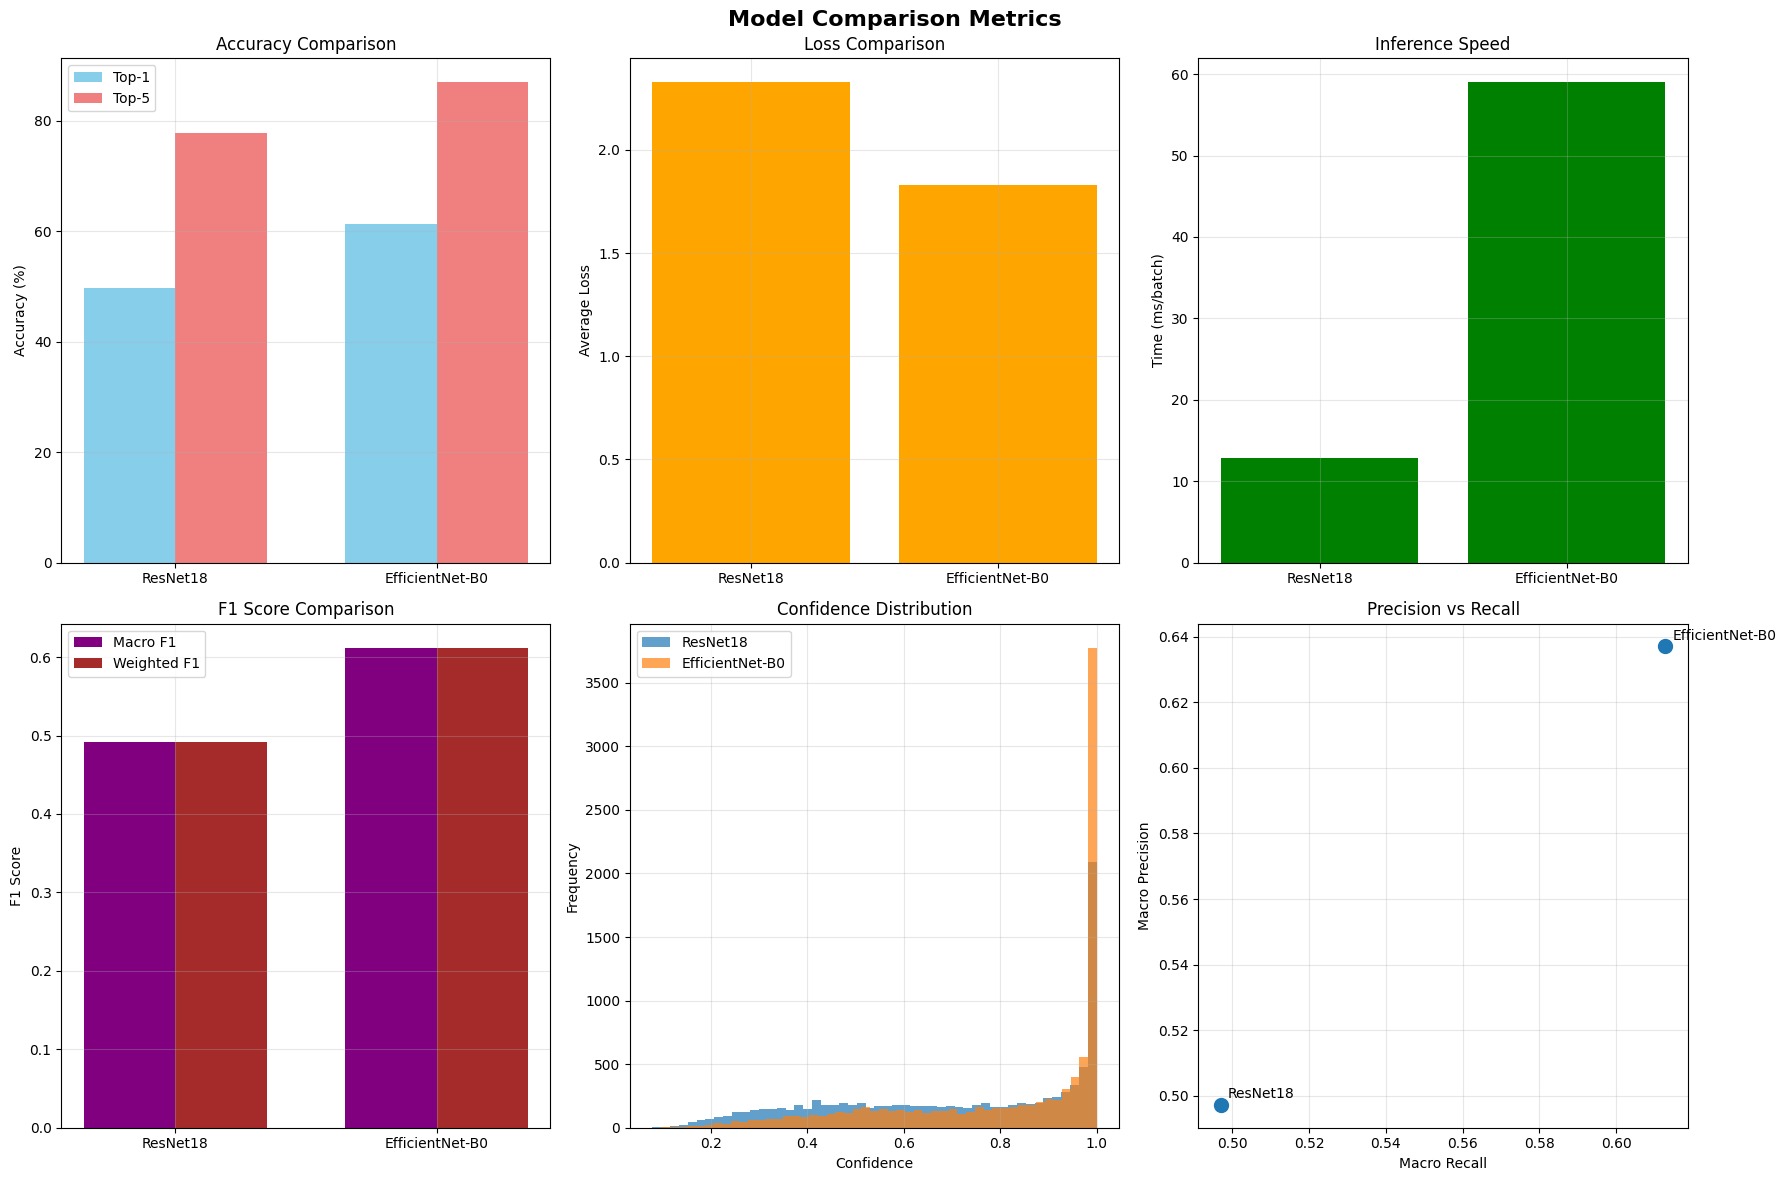


DETAILED COMPARISON TABLE
          Model Top-1 Acc (%) Top-5 Acc (%) Avg Loss Inference (ms)    Confidence Macro F1 Weighted F1
       ResNet18         49.70         77.80   2.3274          12.86 0.707 ± 0.258    0.492       0.492
EfficientNet-B0         61.28         86.96   1.8321          58.99 0.812 ± 0.226    0.612       0.612

MODEL SIZE ANALYSIS

ResNet18:
   Total Parameters: 11,227,812
   Trainable Parameters: 11,227,812
   Model Size: ~42.8 MB

EfficientNet-B0:
   Total Parameters: 4,135,648
   Trainable Parameters: 4,135,648
   Model Size: ~15.8 MB


In [21]:
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

def comprehensive_evaluate_model(model, test_loader, model_name="Model"):
    """
    Comprehensive evaluation with multiple metrics
    """
    model.eval()
    
    # Initialize tracking variables
    correct = 0
    total = 0
    top5_correct = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []
    total_loss = 0
    inference_times = []
    
    criterion = nn.CrossEntropyLoss()
    
    print(f"\n{'='*50}")
    print(f"EVALUATING {model_name.upper()}")
    print(f"{'='*50}")
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Measure inference time
            start_time = time.time()
            outputs = model(images)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Get probabilities
            probabilities = F.softmax(outputs, dim=1)
            all_probabilities.extend(probabilities.cpu().numpy())
            
            # Top-1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Top-5 accuracy
            _, top5_pred = outputs.topk(5, 1, True, True)
            top5_correct += top5_pred.eq(labels.view(-1, 1).expand_as(top5_pred)).sum().item()
            
            # Store for detailed metrics
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = 100 * correct / total
    top5_accuracy = 100 * top5_correct / total
    avg_loss = total_loss / len(test_loader)
    avg_inference_time = np.mean(inference_times)
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)
    
    # Calculate confidence metrics
    max_confidences = np.max(all_probabilities, axis=1)
    avg_confidence = np.mean(max_confidences)
    confidence_std = np.std(max_confidences)
    
    # Print basic metrics
    print(f"📊 ACCURACY METRICS:")
    print(f"   Top-1 Accuracy: {accuracy:.2f}%")
    print(f"   Top-5 Accuracy: {top5_accuracy:.2f}%")
    print(f"   Average Loss: {avg_loss:.4f}")
    
    print(f"\n⚡ PERFORMANCE METRICS:")
    print(f"   Avg Inference Time: {avg_inference_time*1000:.2f} ms/batch")
    print(f"   Throughput: {len(test_loader.dataset)/sum(inference_times):.1f} samples/sec")
    
    print(f"\n🎯 CONFIDENCE METRICS:")
    print(f"   Average Confidence: {avg_confidence:.3f}")
    print(f"   Confidence Std: {confidence_std:.3f}")
    
    # Calculate per-class metrics
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_predictions, average=None, zero_division=0
    )
    
    # Macro averages
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    
    # Weighted averages
    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1 = np.average(f1, weights=support)
    
    print(f"\n📈 CLASSIFICATION METRICS:")
    print(f"   Macro Precision: {macro_precision:.3f}")
    print(f"   Macro Recall: {macro_recall:.3f}")
    print(f"   Macro F1-Score: {macro_f1:.3f}")
    print(f"   Weighted Precision: {weighted_precision:.3f}")
    print(f"   Weighted Recall: {weighted_recall:.3f}")
    print(f"   Weighted F1-Score: {weighted_f1:.3f}")
    
    return {
        'model_name': model_name,
        'top1_accuracy': accuracy,
        'top5_accuracy': top5_accuracy,
        'avg_loss': avg_loss,
        'avg_inference_time': avg_inference_time,
        'avg_confidence': avg_confidence,
        'confidence_std': confidence_std,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall,
        'weighted_f1': weighted_f1,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities
    }

def plot_comparison_metrics(results_list):
    """
    Plot comparison between models
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Model Comparison Metrics', fontsize=16, fontweight='bold')
    
    models = [r['model_name'] for r in results_list]
    
    # 1. Accuracy Comparison
    top1_acc = [r['top1_accuracy'] for r in results_list]
    top5_acc = [r['top5_accuracy'] for r in results_list]
    
    x = np.arange(len(models))
    width = 0.35
    
    axes[0,0].bar(x - width/2, top1_acc, width, label='Top-1', color='skyblue')
    axes[0,0].bar(x + width/2, top5_acc, width, label='Top-5', color='lightcoral')
    axes[0,0].set_ylabel('Accuracy (%)')
    axes[0,0].set_title('Accuracy Comparison')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Loss Comparison
    losses = [r['avg_loss'] for r in results_list]
    axes[0,1].bar(models, losses, color='orange')
    axes[0,1].set_ylabel('Average Loss')
    axes[0,1].set_title('Loss Comparison')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Inference Time
    times = [r['avg_inference_time']*1000 for r in results_list]
    axes[0,2].bar(models, times, color='green')
    axes[0,2].set_ylabel('Time (ms/batch)')
    axes[0,2].set_title('Inference Speed')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. F1 Scores
    macro_f1 = [r['macro_f1'] for r in results_list]
    weighted_f1 = [r['weighted_f1'] for r in results_list]
    
    axes[1,0].bar(x - width/2, macro_f1, width, label='Macro F1', color='purple')
    axes[1,0].bar(x + width/2, weighted_f1, width, label='Weighted F1', color='brown')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].set_title('F1 Score Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(models)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Confidence Distribution
    for i, result in enumerate(results_list):
        confidences = np.max(result['probabilities'], axis=1)
        axes[1,1].hist(confidences, bins=50, alpha=0.7, label=result['model_name'])
    axes[1,1].set_xlabel('Confidence')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Confidence Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Precision-Recall
    precisions = [r['macro_precision'] for r in results_list]
    recalls = [r['macro_recall'] for r in results_list]
    
    axes[1,2].scatter(recalls, precisions, s=100)
    for i, model in enumerate(models):
        axes[1,2].annotate(model, (recalls[i], precisions[i]), 
                          xytext=(5, 5), textcoords='offset points')
    axes[1,2].set_xlabel('Macro Recall')
    axes[1,2].set_ylabel('Macro Precision')
    axes[1,2].set_title('Precision vs Recall')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_comparison_table(results_list):
    """
    Create a detailed comparison table
    """
    import pandas as pd
    
    comparison_data = []
    for result in results_list:
        comparison_data.append({
            'Model': result['model_name'],
            'Top-1 Acc (%)': f"{result['top1_accuracy']:.2f}",
            'Top-5 Acc (%)': f"{result['top5_accuracy']:.2f}",
            'Avg Loss': f"{result['avg_loss']:.4f}",
            'Inference (ms)': f"{result['avg_inference_time']*1000:.2f}",
            'Confidence': f"{result['avg_confidence']:.3f} ± {result['confidence_std']:.3f}",
            'Macro F1': f"{result['macro_f1']:.3f}",
            'Weighted F1': f"{result['weighted_f1']:.3f}"
        })
    
    df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("DETAILED COMPARISON TABLE")
    print("="*80)
    print(df.to_string(index=False))
    
    return df

# Model parameter count
def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def model_size_analysis(models_dict):
    """Analyze model sizes"""
    print(f"\n{'='*50}")
    print("MODEL SIZE ANALYSIS")
    print(f"{'='*50}")
    
    for name, model in models_dict.items():
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = count_parameters(model)
        
        print(f"\n{name}:")
        print(f"   Total Parameters: {total_params:,}")
        print(f"   Trainable Parameters: {trainable_params:,}")
        print(f"   Model Size: ~{total_params * 4 / (1024**2):.1f} MB")

# Usage example:
print("Evaluating ResNet18...")
resnet_results = comprehensive_evaluate_model(resnet, test_loader, "ResNet18")

print("\nEvaluating EfficientNet-B0...")
efficientnet_results = comprehensive_evaluate_model(efficientnet, test_loader, "EfficientNet-B0")

# Create comparison visualizations
plot_comparison_metrics([resnet_results, efficientnet_results])

# Create comparison table
comparison_df = create_comparison_table([resnet_results, efficientnet_results])

# Model size analysis
model_size_analysis({
    'ResNet18': resnet,
    'EfficientNet-B0': efficientnet
})

In [28]:
# efficientnetv2 = models.efficientnet_v2_s(weights='DEFAULT')

# class Efficientv2(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(Efficientv2, self).__init__()
#         self.model = models.efficientnet_v2_s(weights='DEFAULT')
#         self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

#     def forward(self, x):
#         return self.model(x)

# efficientnetv2 = Efficientv2(num_classes=1000).to(device)


In [ ]:
# train_model(efficientnetv2, train_loader_fast, criterion, optimizer_efficientnet, num_epochs=5)

Epoch [1/5], Loss: 7.8511
Epoch [2/5], Loss: 7.8607
Epoch [3/5], Loss: 7.8800
Epoch [4/5], Loss: 7.8820
Epoch [5/5], Loss: 7.8927


In [ ]:
# evaluate_model(efficientnetv2, test_loader)

Accuracy of the model on the test set: 0.40%


In [30]:
### Saving the model 

torch.save(resnet.state_dict(), 'resnet18.pth')
torch.save(efficientnet.state_dict(), 'efficientnet.pth')   
# torch.save(fast_model.state_dict(), 'fast_vgg.pth')


🔍 Evaluating ResNet18...

METRICS FOR RESNET18
📊 ACCURACY: 49.70%

📈 CLASSIFICATION METRICS:
   Precision (Macro):    0.4973
   Precision (Weighted): 0.4973
   Recall (Macro):       0.4970
   Recall (Weighted):    0.4970
   F1-Score (Macro):     0.4918
   F1-Score (Weighted):  0.4918

🎯 AUC SCORES:
   AUC (Macro):     0.9606
   AUC (Weighted):  0.9606

🏆 TOP-5 ACCURACY: 77.80%


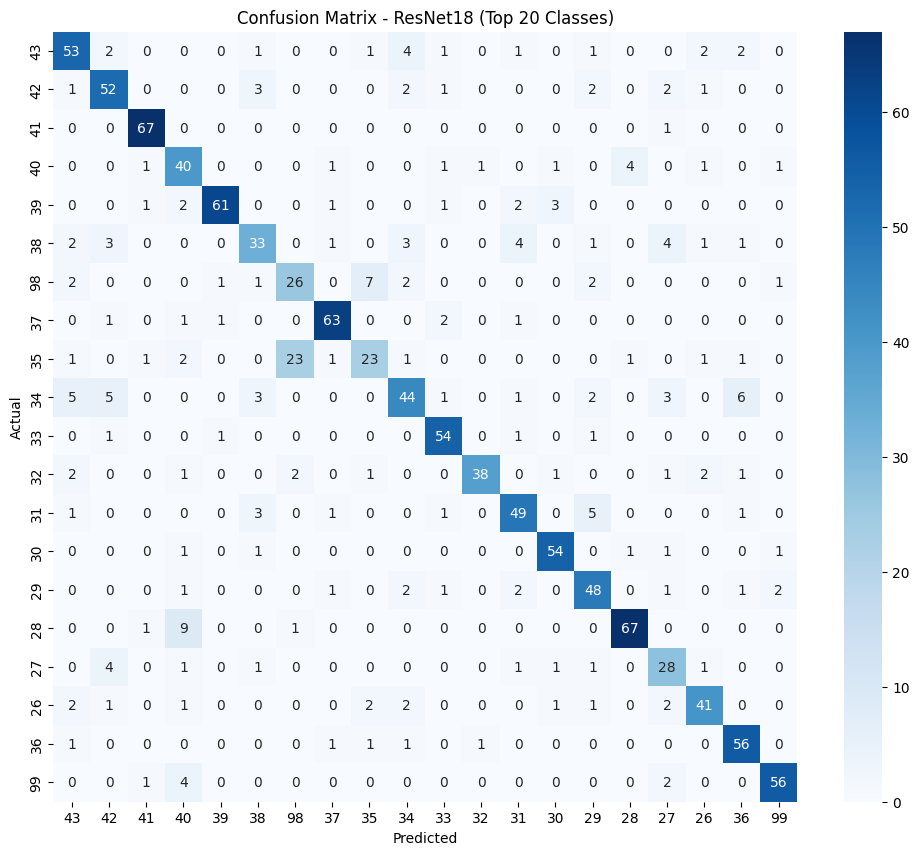


🔍 Evaluating EfficientNet-B0...

METRICS FOR EFFICIENTNET-B0
📊 ACCURACY: 61.28%

📈 CLASSIFICATION METRICS:
   Precision (Macro):    0.6370
   Precision (Weighted): 0.6370
   Recall (Macro):       0.6128
   Recall (Weighted):    0.6128
   F1-Score (Macro):     0.6121
   F1-Score (Weighted):  0.6121

🎯 AUC SCORES:
   AUC (Macro):     0.9777
   AUC (Weighted):  0.9777

🏆 TOP-5 ACCURACY: 86.96%


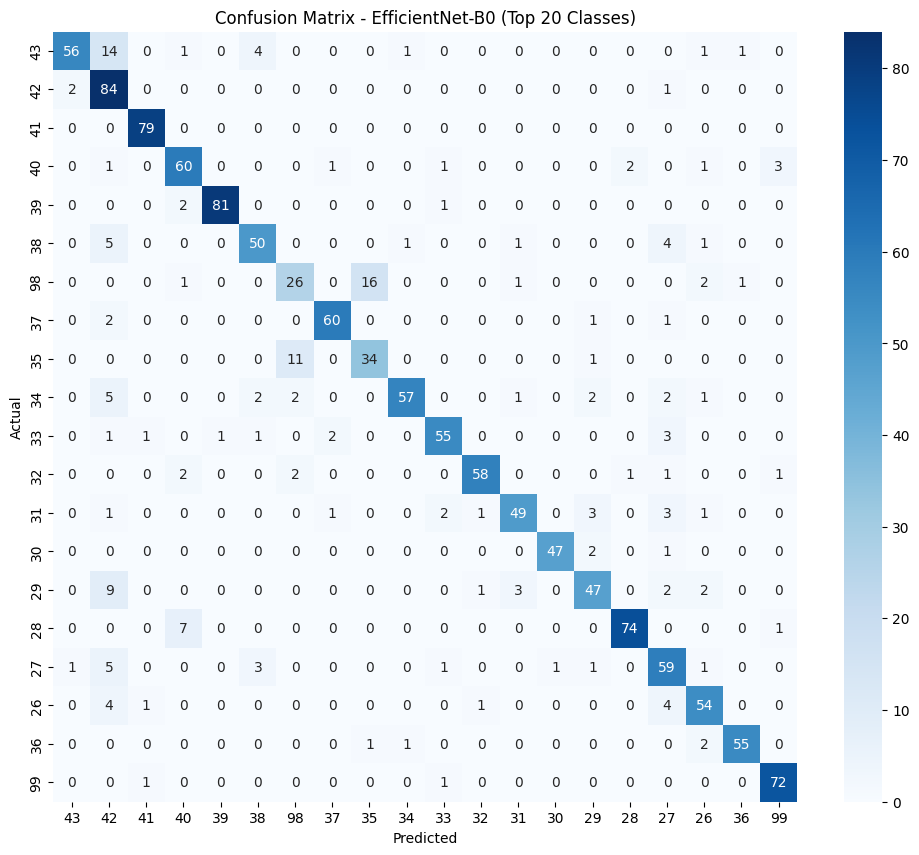


MODEL COMPARISON SUMMARY
Model           Accuracy   F1-Macro   F1-Weighted  Top-5 Acc  AUC-Macro 
--------------------------------------------------------------------------------
ResNet18        49.70    % 0.4918    0.4918      77.80    % 0.9606   
EfficientNet-B0 61.28    % 0.6121    0.6121      86.96    % 0.9777   

DETAILED CLASSIFICATION REPORT

Classification Report (First 10 classes):
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       100
           1       0.99      0.76      0.86       100
           2       0.96      0.53      0.68       100
           3       0.92      0.34      0.50       100
           4       0.86      0.37      0.52       100
           5       0.99      0.72      0.83       100
           6       0.95      0.60      0.74       100
           7       0.92      0.68      0.78       100
           8       1.00      0.67      0.80       100
           9       0.98      0.84      0.90       100

   micro 

In [35]:
from sklearn.metrics import auc, roc_curve


import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, 
    confusion_matrix, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

def get_model_predictions_and_labels(model, test_loader):
    """
    Get predictions and true labels from a model
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)

def calculate_comprehensive_metrics(y_true, y_pred, y_prob, model_name="Model"):
    """
    Calculate comprehensive metrics for multi-class classification
    """
    print(f"\n{'='*60}")
    print(f"METRICS FOR {model_name.upper()}")
    print(f"{'='*60}")
    
    # Basic accuracy
    accuracy = accuracy_score(y_true, y_pred) * 100
    print(f"📊 ACCURACY: {accuracy:.2f}%")
    
    # Per-class metrics
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n📈 CLASSIFICATION METRICS:")
    print(f"   Precision (Macro):    {precision_macro:.4f}")
    print(f"   Precision (Weighted): {precision_weighted:.4f}")
    print(f"   Recall (Macro):       {recall_macro:.4f}")
    print(f"   Recall (Weighted):    {recall_weighted:.4f}")
    print(f"   F1-Score (Macro):     {f1_macro:.4f}")
    print(f"   F1-Score (Weighted):  {f1_weighted:.4f}")
    
    # AUC for multi-class (one-vs-rest)
    try:
        auc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
        auc_weighted = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
        print(f"\n🎯 AUC SCORES:")
        print(f"   AUC (Macro):     {auc_macro:.4f}")
        print(f"   AUC (Weighted):  {auc_weighted:.4f}")
    except Exception as e:
        print(f"\n⚠️ AUC calculation failed: {e}")
        auc_macro = auc_weighted = 0.0
    
    # Top-5 accuracy for CIFAR-100
    top5_correct = 0
    for i in range(len(y_true)):
        true_label = y_true[i]
        top5_preds = np.argsort(y_prob[i])[-5:]
        if true_label in top5_preds:
            top5_correct += 1
    
    top5_accuracy = (top5_correct / len(y_true)) * 100
    print(f"\n🏆 TOP-5 ACCURACY: {top5_accuracy:.2f}%")
    
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'auc_macro': auc_macro,
        'auc_weighted': auc_weighted,
        'top5_accuracy': top5_accuracy
    }

def plot_confusion_matrix(y_true, y_pred, model_name, top_n_classes=20):
    """
    Plot confusion matrix for top N classes
    """
    # Get top N most frequent classes
    unique_classes, counts = np.unique(y_true, return_counts=True)
    top_classes_idx = np.argsort(counts)[-top_n_classes:]
    top_classes = unique_classes[top_classes_idx]
    
    # Filter predictions and labels for top classes
    mask = np.isin(y_true, top_classes)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    # Create confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_classes)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=top_classes, yticklabels=top_classes)
    plt.title(f'Confusion Matrix - {model_name} (Top {top_n_classes} Classes)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def compare_models(models_dict, test_loader):
    """
    Compare multiple models and display results
    """
    results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n🔍 Evaluating {model_name}...")
        y_pred, y_true, y_prob = get_model_predictions_and_labels(model, test_loader)
        metrics = calculate_comprehensive_metrics(y_true, y_pred, y_prob, model_name)
        results[model_name] = metrics
        
        # Plot confusion matrix
        plot_confusion_matrix(y_true, y_pred, model_name)
    
    # Create comparison table
    print(f"\n{'='*80}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'='*80}")
    
    print(f"{'Model':<15} {'Accuracy':<10} {'F1-Macro':<10} {'F1-Weighted':<12} {'Top-5 Acc':<10} {'AUC-Macro':<10}")
    print("-" * 80)
    
    for model_name, metrics in results.items():
        print(f"{model_name:<15} {metrics['accuracy']:<9.2f}% {metrics['f1_macro']:<9.4f} "
              f"{metrics['f1_weighted']:<11.4f} {metrics['top5_accuracy']:<9.2f}% {metrics['auc_macro']:<9.4f}")
    
    return results

# Usage: Compare your models
models_to_compare = {
    'ResNet18': resnet,
    'EfficientNet-B0': efficientnet
}

# Run comprehensive evaluation
comparison_results = compare_models(models_to_compare, test_loader)

# Additional detailed classification report for best model
print(f"\n{'='*80}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*80}")

# Get predictions for the best performing model (you can change this)
best_model = efficientnet  # or resnet based on your results
y_pred, y_true, y_prob = get_model_predictions_and_labels(best_model, test_loader)

# Show classification report for first 10 classes (to avoid too much output)
unique_classes = np.unique(y_true)[:10]
mask = np.isin(y_true, unique_classes)
print("\nClassification Report (First 10 classes):")
print(classification_report(y_true[mask], y_pred[mask], labels=unique_classes, zero_division=0))


### testing the model metrics 

C:\Users\Kavitha padala\AppData\Local\Temp\ipykernel_24624\3724435305.py:56: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


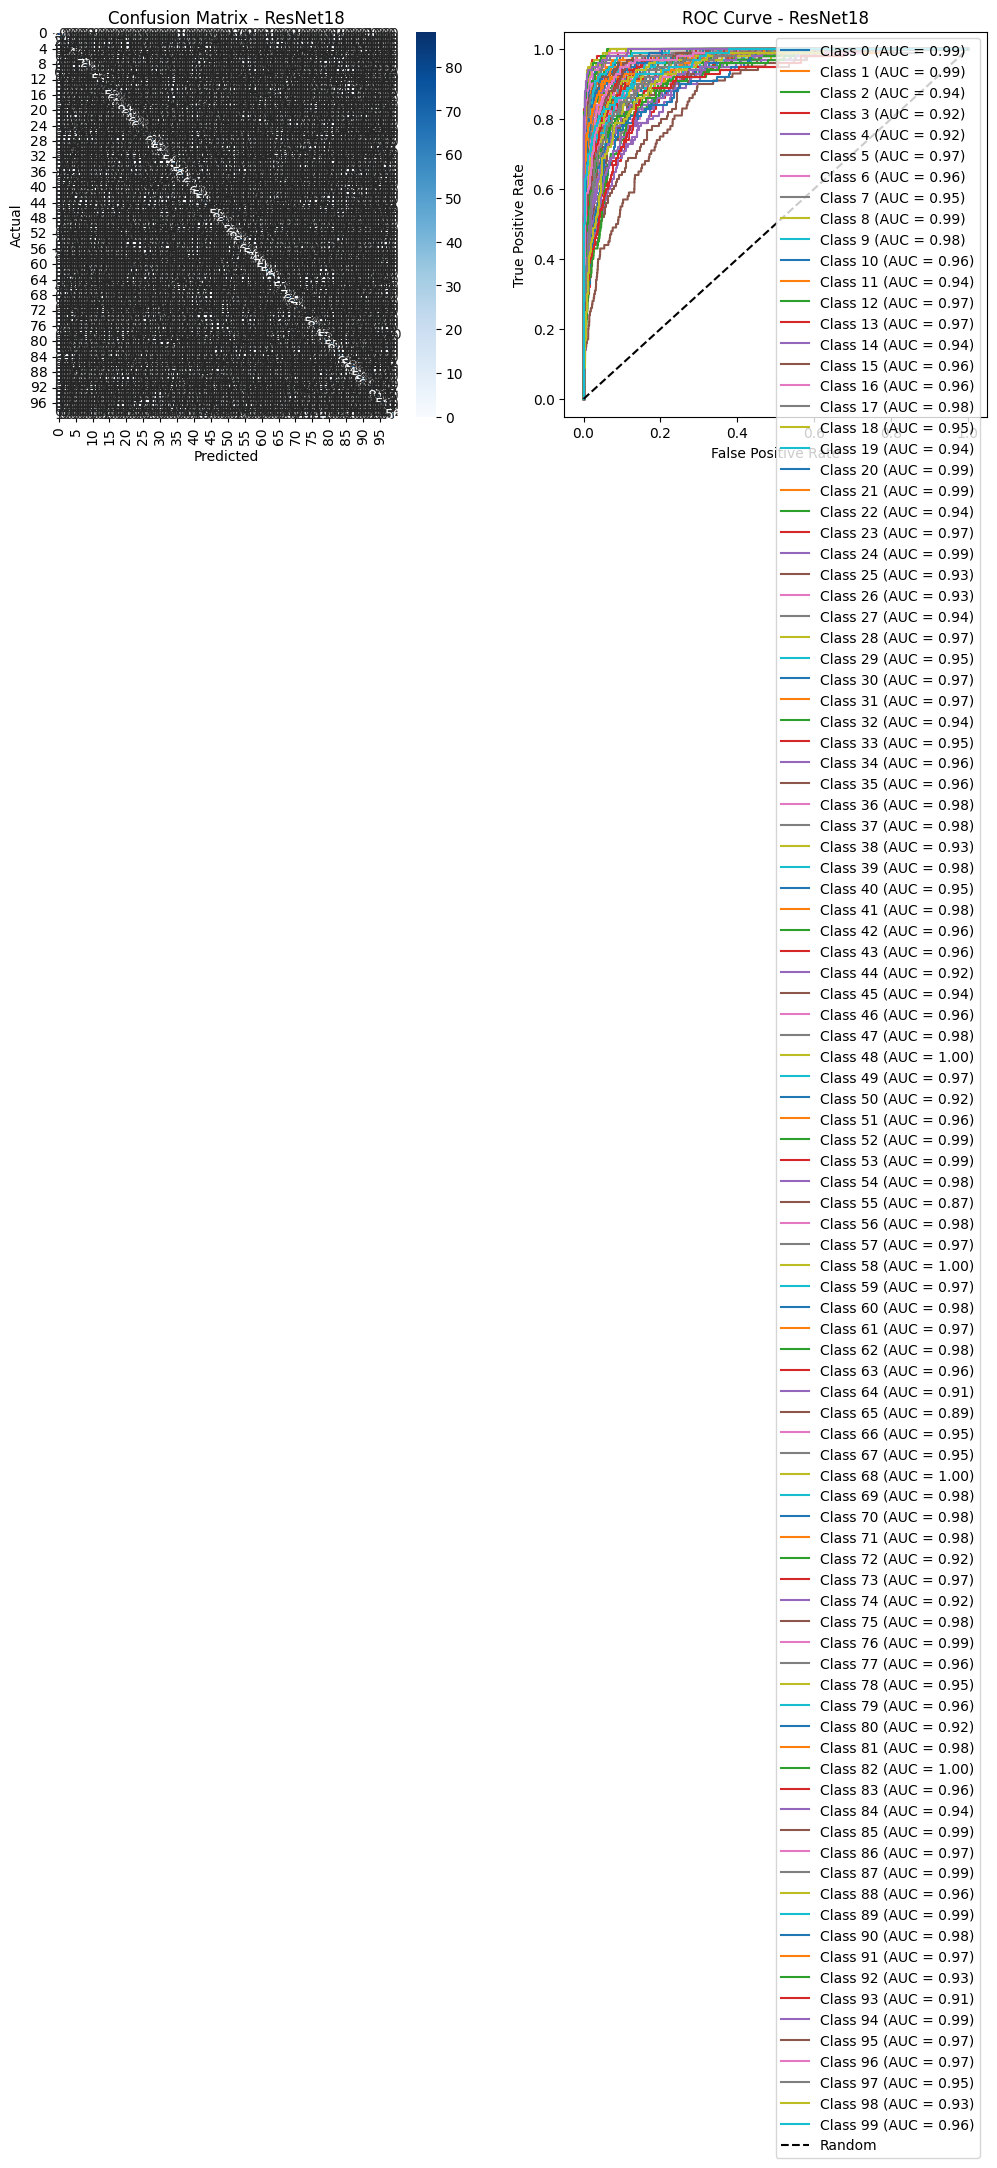

In [ ]:
def get_model_predictions_and_labels(model, test_loader):
    """
    Get predictions and true labels from a model
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def visualize_model_performance_multiclass(y_true, y_pred, y_prob, model_name="Model"):
    """
    Visualize model performance for multiclass classification
    """
    plt.figure(figsize=(12, 5))

    # 1️⃣ Confusion Matrix
    plt.subplot(1, 2, 1)
    # sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 2️⃣ ROC Curves (One-vs-Rest)
    plt.subplot(1, 2, 2)
    n_classes = y_prob.shape[1]
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()

y_pred, y_true, y_prob = get_model_predictions_and_labels(resnet, test_loader)

visualize_model_performance_multiclass(y_true, y_pred, y_prob, model_name="ResNet18")

C:\Users\Kavitha padala\AppData\Local\Temp\ipykernel_24624\1154501710.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


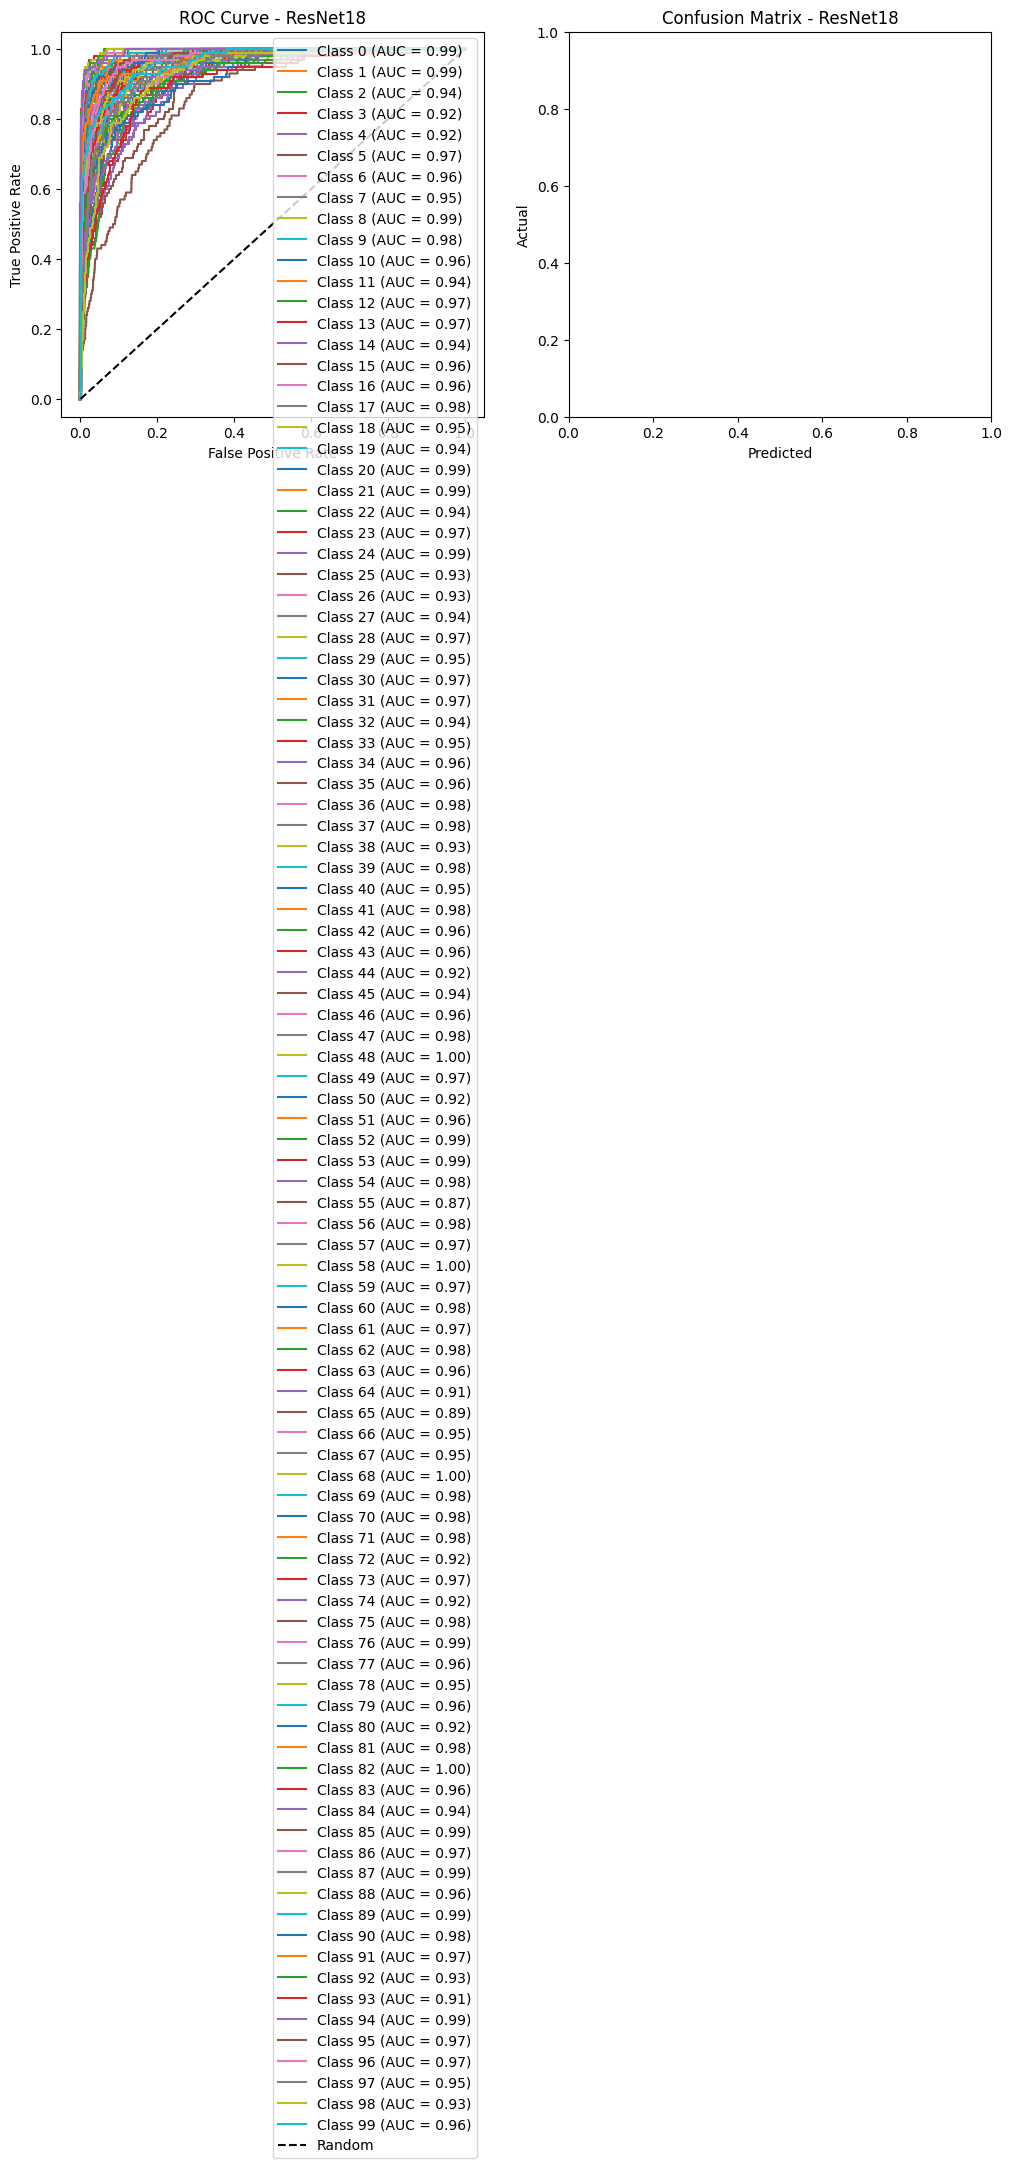

In [41]:

def visualize_model_performance_multiclass(y_true, y_pred, y_prob, model_name="Model"):
    """
    Visualize model performance for multiclass classification
    """
    plt.figure(figsize=(12, 5))

    # 1️⃣ Confusion Matrix
    plt.subplot(1, 2, 2)
    # sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 2️⃣ ROC Curves (One-vs-Rest)
    plt.subplot(1, 2, 1)
    n_classes = y_prob.shape[1]
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()
visualize_model_performance_multiclass(y_true, y_pred, y_prob, model_name="ResNet18")

C:\Users\Kavitha padala\AppData\Local\Temp\ipykernel_24624\3207060076.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


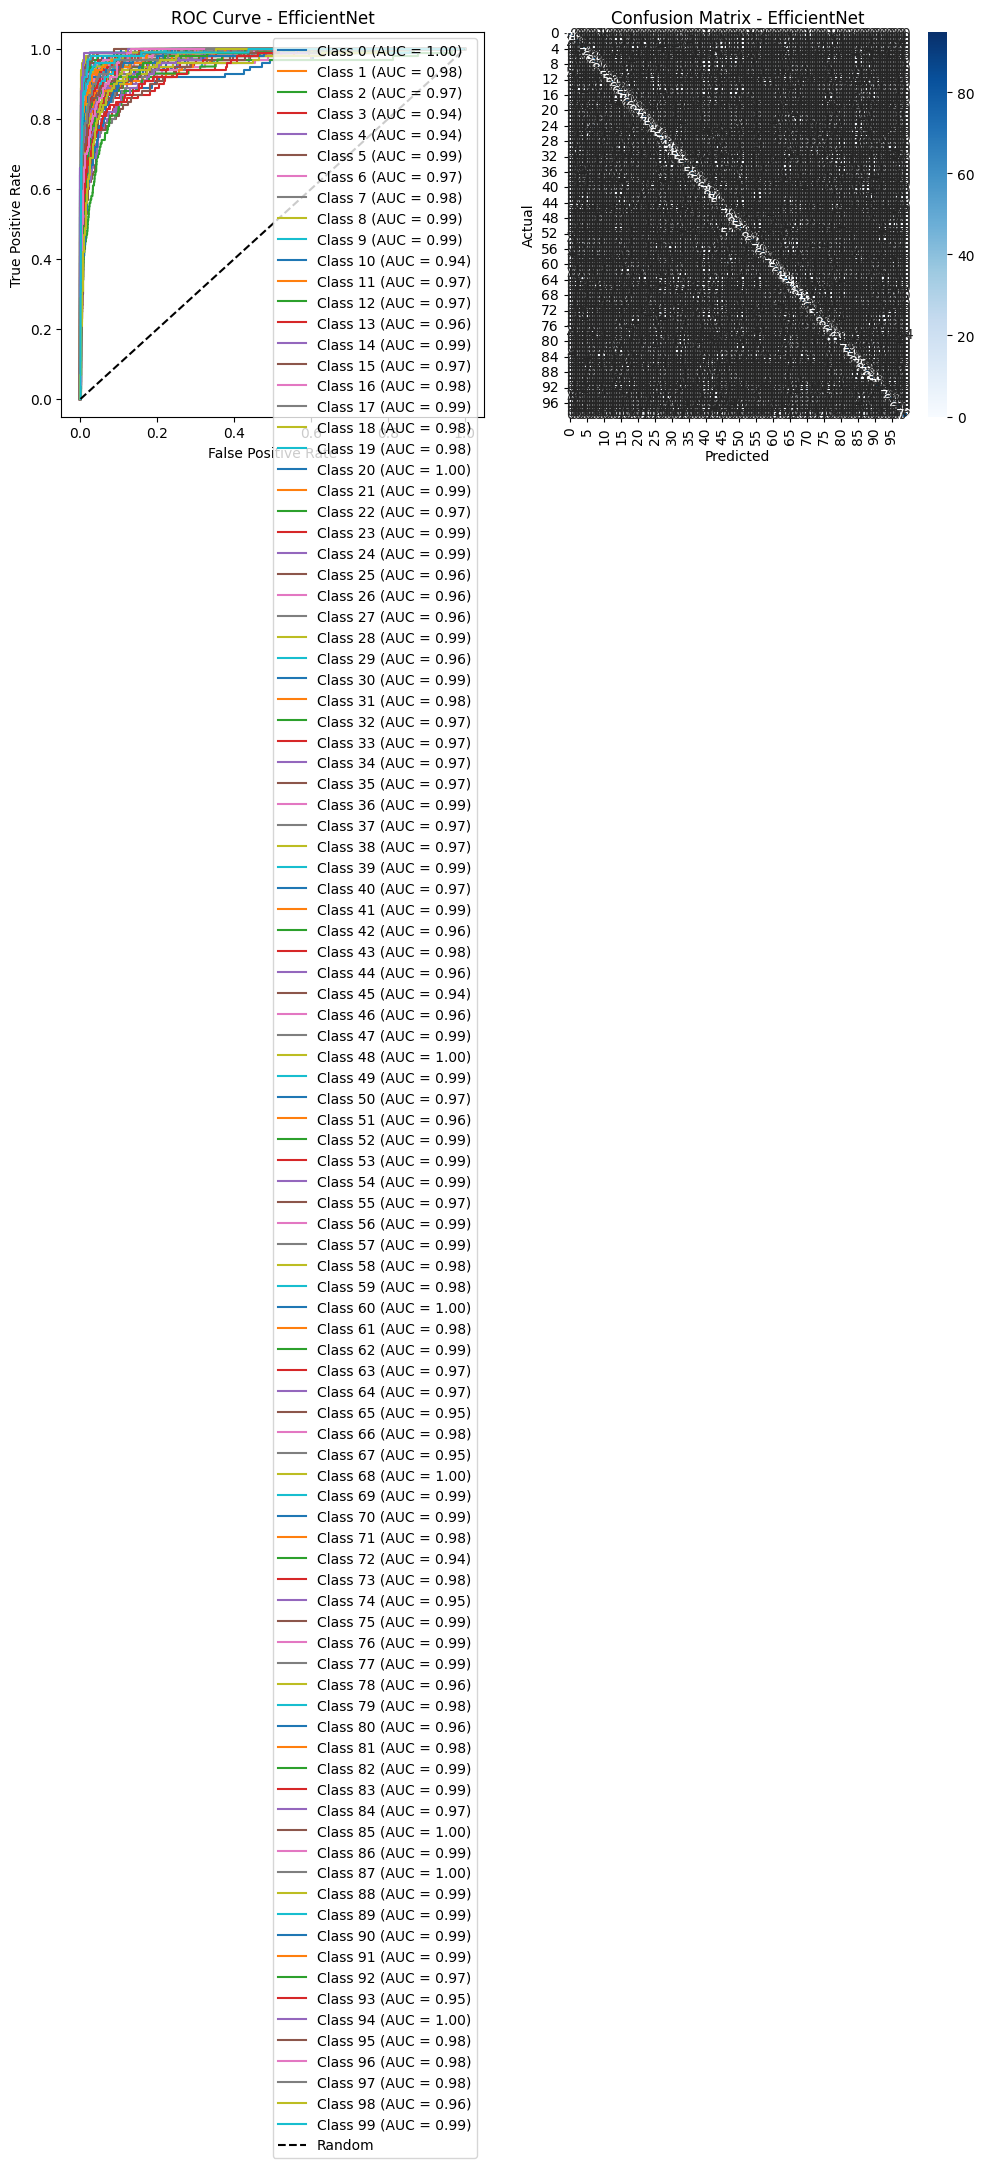

In [43]:
def visualize_model_performance_multiclass(y_true, y_pred, y_prob, model_name="Model"):
    """
    Visualize model performance for multiclass classification
    """
    plt.figure(figsize=(12, 5))

    # 1️⃣ Confusion Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 2️⃣ ROC Curves (One-vs-Rest)
    plt.subplot(1, 2, 1)
    n_classes = y_prob.shape[1]
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()


y_pred, y_true, y_prob = get_model_predictions_and_labels(efficientnet, test_loader)

visualize_model_performance_multiclass(y_true, y_pred, y_prob, model_name="EfficientNet")

In [48]:
###  convnext_tiny 


print("Hello World")

from torchvision import models

convnext_tiny = models.convnext_tiny(pretrained=True)
print(convnext_tiny)
class ConvNeXTinyModel(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeXTinyModel, self).__init__()
        self.base_model = convnext_tiny
        print(self.base_model.classifier[2].in_features)
        self.fc = nn.Linear(self.base_model.classifier[2].in_features, num_classes)
        # self.fc = nn.Linear(self.base_model.classifier.features, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x
    
convnext_tiny_model = ConvNeXTinyModel(num_classes=100).to(device)

Hello World


c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import convnext_tiny

class ConvNeXTinyModel(nn.Module):
    def __init__(self, num_classes=100):
        super(ConvNeXTinyModel, self).__init__()
        self.base_model = convnext_tiny(pretrained=True)  # or weights="DEFAULT"
        # Replace the Linear layer in the classifier
        for param in self.base_model.parameters():
            param.requires_grad = False
        self.base_model.classifier[2] = nn.Linear(768, num_classes)

    def forward(self, x):
        x = self.base_model(x)  # Use the entire model, including the modified classifier
        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
convnext_tiny_model = ConvNeXTinyModel(num_classes=100).to(device)

# Define optimizer and criterion
optimizer_convnext = torch.optim.Adam(convnext_tiny_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Example training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}] completed")

# Assuming train_loader_fast is defined
train_model(convnext_tiny_model, train_loader_fast, criterion, optimizer_convnext, num_epochs=5)


# optimizer_convnext = torch.optim.Adam(convnext_tiny_model.parameters(), lr=1e-4)


# train_model(convnext_tiny_model, train_loader_fast, criterion, optimizer_convnext, num_epochs=5)


 


c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] completed
Epoch [2/5] completed
Epoch [3/5] completed
Epoch [4/5] completed
Epoch [5/5] completed


In [54]:
convnext_tiny_model.eval()

evaluate_model(convnext_tiny_model, test_loader)

Accuracy of the model on the test set: 60.04%


ValueError: Input contains NaN.

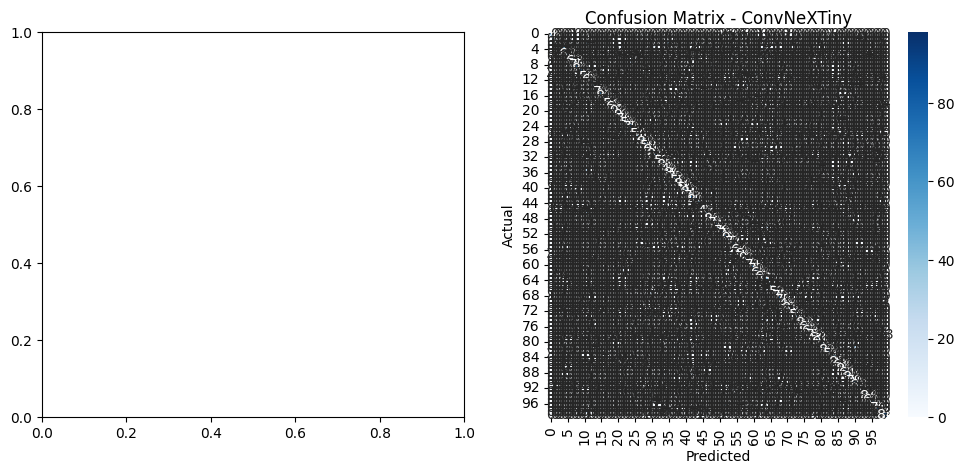

In [55]:

y_pred, y_true, y_prob = get_model_predictions_and_labels(convnext_tiny_model, test_loader)

visualize_model_performance_multiclass(y_true, y_pred, y_prob, model_name="ConvNeXTiny")